In [205]:
import pandas as pd
import numpy as np
import os 

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
import torchvision.utils as utils
import torch.optim as optim

import matplotlib.pyplot as plt

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

from torch.utils.data import SubsetRandomSampler
from sklearn.metrics import confusion_matrix

8 Class classification problem 

Initially work on trying to classifiy based on google search scraped pictures of these lightbulbs.
The problem with this is that they nearly always have a white backgroud and are not realistic of a phone camera version
of a picture of the light bulb
'current search: B15 light bulbs'

Classes
E27 light bulbs
E14 light bulbs
B22 light bulbs
B15 light bulbs
GU10 light bulbs
G4
G9
MR16


Need to also buy some examples of the light bulbs as a way of building up my own dataset that might be more realistic.


# Support functions

In [206]:
folders = ['B15','B22','E14', 'E27', 'G4', 'G9','GU10', 'MR16']

def file_rename(folders):
    '''
    Function to rename all files taken from the internet from training.Used to rename
    all the file names to avoid really long file names and make it easier to know which
    bulb it is.
    
    Could be made more generic for other projects. Eg move out the base location into a parameter.
    
    input - folder names
    
    output - all files renamed in place. 
    
    '''
    
    for bulb_type in folders:

        location = r"C:\Users\awalker8\Documents\COVID_Furlow\bulb_class\bulb_data"
        location = location + '\\' + bulb_type + '\\'
        print(location)
        for count, filename in enumerate(os.listdir(location)): 
            dst = bulb_type + str(count) + ".jpg"
            src = location + filename 
            dst = location + dst 
            # rename() function will 
            # rename all the files 
            os.rename(src, dst) 

In [207]:
def create_separate_train_dev_test( dataset, percentages = [0.8,0.1,0.1]):
    '''
    Function to create separate dataloaders for test dev and train.
    
    Inputs - list of percentage breakdowns [train, dev , test] Must add to 1. 
    # Add in test to check for this ~
    
    Outputs - each dataloader.
    
    '''

    indices = list(range(len(light_bulbs)))
    train_amount =0.8
    dev = 0.1
    test = 0.1

    split_1 = int(np.floor(len(light_bulbs)*0.8))
    split_2 = int(np.floor(len(light_bulbs)*0.9))

    np.random.seed(0)
    np.random.shuffle(indices)

    train_indices, dev_indices, test_indices = indices[:split_1], indices[split_1:split_2],indices[split_2:]

    train_sampler = SubsetRandomSampler(train_indices)
    dev_sampler = SubsetRandomSampler(dev_indices)
    test_sampler = SubsetRandomSampler(test_indices)

    dataloader_train = torch.utils.data.DataLoader(light_bulbs,
                                                 batch_size=64,
                                                 num_workers=0 , sampler = train_sampler)

    dataloader_dev = torch.utils.data.DataLoader(light_bulbs,
                                                 batch_size=1,
                                                 num_workers=0 , sampler = dev_sampler)

    dataloader_test = torch.utils.data.DataLoader(light_bulbs,
                                                 batch_size=1,
                                                 num_workers=0 , sampler = test_sampler)
    
    return dataloader_train, dataloader_dev, dataloader_test

In [208]:
def print_examples(dataloader, number_to_show =4):
    i=0
    for x, y in dataloader:  
        out = np.reshape(x[i].numpy(),newshape =[x[i].shape[1],x[i].shape[2],x[i].shape[0]])
        plt.imshow(out)
        plt.title('Bulb type {}'.format(y[i]))
        plt.show()
        
        i = i + 1
        if i == number_to_show:
            break

# Datasets

In [209]:
# Create a pytorch dataset, and then dataloader to allow for mini-batch processing. 
data_transform = transforms.Compose([
        transforms.Resize(255),
        transforms.CenterCrop(128),
        #transforms.RandomSizedCrop(256),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
        ])
    
light_bulbs = datasets.ImageFolder(root=r'C:\Users\awalker8\Documents\COVID_Furlow\bulb_class\bulb_data',
                                           transform=data_transform)
    

In [210]:
train, dev, test = create_separate_train_dev_test(light_bulbs, percentages = [0.8,0.1,0.1])

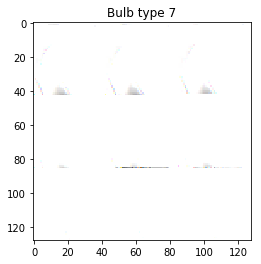

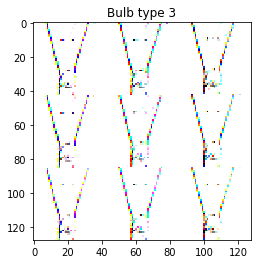

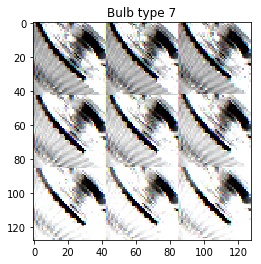

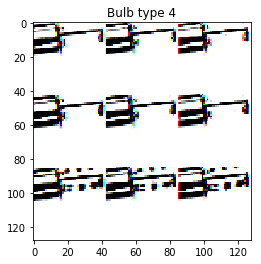

In [211]:
print_examples(train, number_to_show =4)

# CNN

In [212]:
# Defining the weights_init function that takes as input a neural network m and that will initialize all its weights.
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [213]:
# Define the classifier

class bulb_model(nn.Module):
    
    def __init__(self):
        super(bulb_model, self).__init__()
    
        self.main = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            # add a max pooling layer
            nn.MaxPool2d(kernel_size =3 , stride=1, padding=0),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace = True), 
            nn.Conv2d(128, 256, 4, 2, 1, bias = False), 
            nn.MaxPool2d(kernel_size =2 , stride=1, padding=0),
            nn.BatchNorm2d(256), 
            nn.LeakyReLU(0.2, inplace = True), 
            nn.Conv2d(256, 512, 4, 2, 1, bias = False),
            nn.BatchNorm2d(512), 
            nn.LeakyReLU(0.2, inplace = True), 
            nn.Conv2d(512, 10, 4, 1, 0, bias = False), 
            nn.Flatten(),
            nn.Linear(160, 512),
            nn.Dropout(p=0.2),
            nn.Linear(512, 128),
            nn.Dropout(p=0.2),
            nn.Linear(128, 10),
            nn.Softmax()
        )
        
    def forward(self, input):
        output = self.main(input)
        return output

In [214]:
classifier_1 = bulb_model()
classifier_1.apply(weights_init)

bulb_model(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (11): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Leaky

# Train classifier

In [215]:
# create an optimiser for the classifier
optimiser_bulb = optim.Adam(classifier_1.parameters(), lr=0.002, betas = (0.9,0.999))
# Create a criterion. Lets use cross entropy loss. 
criterion = nn.CrossEntropyLoss(weight=None, size_average=None, ignore_index=-100, reduce=None, reduction='mean')

In [216]:
epochs_total = 25

In [ ]:
for epoch in range(epochs_total):
    i = 1
    for data, labels in train:
     
        # push the image through the network
        prediction = classifier_1(data)
        
        error = criterion(prediction, labels)
        print('[%d/%d][%d/%d] Loss: %.4f' % (epoch, epochs_total, i, len(train),error))
  
        # zero grad
        classifier_1.zero_grad()
        error.backward()
        optimiser_bulb.step()
        
        #if i == 10:
        #   break
            
        i = i + 1

C:\Users\awalker8\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\modules\container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


[0/25][1/57] Loss: 2.3072


C:\Users\awalker8\AppData\Local\Continuum\anaconda3\lib\site-packages\PIL\Image.py:969: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


[0/25][2/57] Loss: 2.3003
[0/25][3/57] Loss: 2.2567


In [ ]:
# confusion matrix on the dev set
# F1 score - going to be my key metric? (for now)

dev_predictions = []
dev_labels = []

for data, labels in dev:
        # push the image through the network
        predictions = classifier_1(data).detach().numpy()
        #print(predictions)
        index  = np.argmax(predictions, axis=1)
        #print(index)
        dev_predictions.append(index)
        actual = labels.detach().numpy()
        dev_labels.append(actual)


In [ ]:
confusion_matrix(dev_labels, dev_predictions)

In [ ]:
from sklearn.metrics import precision_score, recall_score
pre = precision_score(dev_labels, dev_predictions, average='micro')
print('Precision {}'.format(round(pre,3)))
rec = recall_score(dev_labels, dev_predictions, average='micro')
print('Recall {}'.format(round(rec,3)))

# Experimenting with Built from Scratch

What's the problem - high bias

Bigger network,
change the learning rate
change the layers

